# Advantage Actor-Critic
## Using TF-2

### Tested on Atari Kung-Fu Master

In [1]:
import gym
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Preprocess game image!

In [2]:
from gym.core import ObservationWrapper, Wrapper
from gym.spaces import Box

class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (42,42)
        self.observation_space = Box(0.0, 1.0, (self.img_size[0], self.img_size[1], 1))
        
    def observation(self, img):
        
        img = img[60:-30, 5:].astype('float32')
        img = cv2.resize(img/255.,self.img_size, interpolation=cv2.INTER_LINEAR)
        img = img.mean(-1, keepdims=True)
        return img

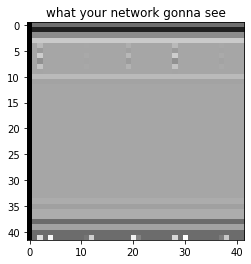

In [3]:
#Start the environment
env = gym.make("KungFuMasterDeterministic-v0")
env = PreprocessAtari(env)

observation_shape = env.observation_space.shape
n_actions = env.action_space.n

obs = env.reset()

plt.title("what your network gonna see")
plt.imshow(obs, interpolation='none', cmap='gray')

### Framebuffer

In [4]:
class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        elif dim_order == 'pytorch':
            n_channels, height, width = env.observation_space.shape
            obs_shape = [n_channels * n_frames, height, width]
        else:
            raise ValueError(
                'dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')

    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer

    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info

    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:, :, :-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate(
            [img, cropped_framebuffer], axis=axis)

In [5]:
def make_env():
    env = gym.make("KungFuMasterDeterministic-v0")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='tensorflow')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
print("n_actions", n_actions)
state_dim = env.observation_space.shape
print("state_dim", state_dim)
print("Action names:", env.env.env.get_action_meanings())

n_actions 14
state_dim (42, 42, 4)
Action names: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


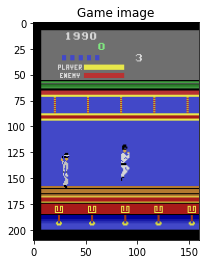

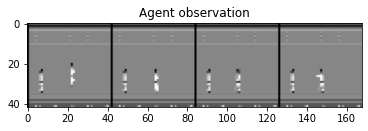

In [6]:
env.reset()
for _ in range(100):
    obs, _, _, _ = env.step(env.action_space.sample())


plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.title("Agent observation")
plt.imshow(obs.transpose([0, 2, 1]).reshape([state_dim[0], -1]), cmap='gray')

## TF Stuff

In [7]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as L

In [8]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Create our DNN model

In [9]:
class OurDNN(keras.Model):
    def __init__(self, input_dim, output_dim):
        super(OurDNN, self).__init__()
        #Input layer
        self.inp = L.InputLayer(input_dim)
#       #Hidden layers
        self.hd1 = L.Conv2D(32, kernel_size=3, strides=2, activation='relu')
        self.hd2 = L.Conv2D(32, kernel_size=3, strides=2, activation='relu')
        self.hd3 = L.Conv2D(32, kernel_size=3, strides=2, activation='relu')
        self.fl1 = L.Flatten()
        self.hd4 = L.Dense(128, activation='relu')
        #Outputs
        self.v_s = L.Dense(1, activation='linear')
        self.logits = L.Dense(output_dim, activation='linear')
        
    @tf.function
    def call(self, input_data):
        #Essentially feedforward your network
        inp_fwd = self.inp(input_data)
        x_fwd = self.hd1(inp_fwd)
        x_fwd = self.hd2(x_fwd)
        x_fwd = self.hd3(x_fwd)
        x_fwd = self.fl1(x_fwd)
        x_fwd = self.hd4(x_fwd)
        #Get Value and Logits
        v_s = self.v_s(x_fwd)
        logits = self.logits(x_fwd)
        #Get the output
        return v_s, logits

## Our A2C agent

#### A2C is a form of policy gradient algorithm

This algorithm basically learns both - value function and the policy while using the former to learn the latter faster.

Advantage is given by,
$$A(s,a) = r+\gamma*V(s') - V(s)$$

The advantage gives an estimate of well... advantage of being in a state rather than just the reward estimate at a state. This is easily visible in its equation

Just like any other policy gradient algorithm, this uses expected discounted reward as the loss function and uses its gradient to update policy. But here we have two loss functions, J_actor and L_critic

$$ J_{actor}(\theta) = -{ 1 \over N } \sum_{i=0}^N \sum_{s_i, a_i} \log \pi_\theta (a_i \mid s_i) \cdot A(s,a) - \lambda*entropy(p)$$

$$L_{critic} = { 1 \over N } \sum_{i=0}^N \sum_{s_i, a_i}(V_\theta - [r + \gamma*V(s')])^2$$

Our network has two outputs, 
$\pi_\theta (a|s)$ and $V_\theta(s)$ to be used for this optimization

In [10]:
class OurAgent:
    def __init__ (self, env, alpha=1e-4, gamma=0.99, lamb=0.001, load=False):
        #Set up constants
        self.state_dim = env.observation_space.shape
        self.n_actions = env.action_space.n
        self.gamma = gamma
        self.env = env
        self.optimizer = keras.optimizers.Adam(alpha)
        self.lamb = lamb
        
        if load:
            self.network = keras.models.load_model("./models/kung-fu")
            self.network.summary()
            print("Loaded old model")
        else:
            #Create model
            self.network = OurDNN(self.state_dim, self.n_actions)
            self.network.compile(self.optimizer)
            print("Created new model")
    
    def get_actions(self, states):
        '''
        Get policy action given the state
        '''
        #Get logits first
        _, logits = self.network(states)
        #Use softmax
#         policy = tf.nn.softmax(logits, axis=-1)
        #Using tf had precision errors
        logits = logits.numpy()
        policy = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
#         print(np.sum(policy, axis=-1))
        return np.array([np.random.choice(self.n_actions, p=p) for p in policy])
    
    def get_losses(self, states, actions, rewards, next_states):
        '''
        Calculate losses using the equations above
        '''
        #Get network outputs
        v_s, logits = self.network(states)
        #Get policy
        policy = tf.nn.softmax(logits, axis=-1)
        #Get log policy
        log_policy = tf.nn.log_softmax(logits, axis=-1)
        #Get log-policy for actions
        indices = tf.stack([tf.range(tf.shape(log_policy)[0]), actions], axis=-1)
        logp_actions = tf.gather_nd(log_policy, indices)
        #Get entropy
        entropy = -tf.reduce_sum(policy*log_policy, axis=1)
        #Get target values
        next_v_s, _ = self.network(next_states)
        target_v_s = rewards + self.gamma*next_v_s
        #Calculate advantage
        advantage = target_v_s - v_s
        #The actor-critic losses
        actor_loss = -tf.reduce_mean(logp_actions*tf.stop_gradient(advantage), axis=0) - self.lamb*tf.reduce_mean(entropy, axis=0)
        critic_loss = tf.reduce_mean((v_s - tf.stop_gradient(target_v_s))**2, axis=0)
        
        return actor_loss, critic_loss, entropy
    
    def train_step(self, states, actions, rewards, next_states):
        '''
        Using the training samples, update params
        '''
        variables = self.network.trainable_variables
        with tf.GradientTape() as tape:
            actor_loss, critic_loss, ent = self.get_losses(states, actions, rewards, next_states)
            loss = actor_loss + critic_loss
            grads = tape.gradient(loss, variables)
            self.optimizer.apply_gradients(zip(grads, variables)) 
        return np.mean(loss), np.mean(ent)    
            
    def save(self):
        self.network.save("./models/kung-fu", save_format="tf")

In [11]:
def evaluate(agent, n_games=1):
    '''
    Plays n_games and returns rewards
    '''
    rewards = []
    env = agent.env
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        while 1:
            a = agent.get_actions(s[None])[0]
            s, r, d, _ = env.step(a)
            reward += r
            if d: break
        rewards.append(reward)
    return np.mean(rewards)

In [12]:
agent = OurAgent(env)

Created new model


## Training on parallel games

In [13]:
class EnvBatch:
    def __init__(self, n_envs = 10):
        """ Creates n_envs environments and babysits them for ya' """
        self.envs = [make_env() for _ in range(n_envs)]
        
    def reset(self):
        """ Reset all games and return [n_envs, *obs_shape] observations """
        return np.array([env.reset() for env in self.envs])
    
    def step(self, actions):
        """
        Send a vector[batch_size] of actions into respective environments
        :returns: observations[n_envs, *obs_shape], rewards[n_envs], done[n_envs,], info[n_envs]
        """
        results = [env.step(a) for env, a in zip(self.envs, actions)]
        new_obs, rewards, done, infos = map(np.array, zip(*results))
        
        # reset environments automatically
        for i in range(len(self.envs)):
            if done[i]:
                new_obs[i] = self.envs[i].reset()
        
        return new_obs, rewards, done, infos

In [14]:
#Test
env_batch = EnvBatch(10)

batch_states = env_batch.reset()
batch_actions = agent.get_actions(batch_states)

batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

print("State shape:", batch_states.shape)
print("Actions:", batch_actions)
print("Rewards:", batch_rewards)
print("Done:", batch_done)

State shape: (10, 42, 42, 4)
Actions: [ 9  6 10 10 10 12  8 13  8  3]
Rewards: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Done: [False False False False False False False False False False]


## Train!

In [15]:
import pandas as pd
import tqdm
from IPython.display import clear_output

def ewma(x, span=100):
    return pd.DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

env_batch = EnvBatch(10)
batch_states = env_batch.reset()

rewards_history = []
entropy_history = []

Mean reward:  566.6666666666666


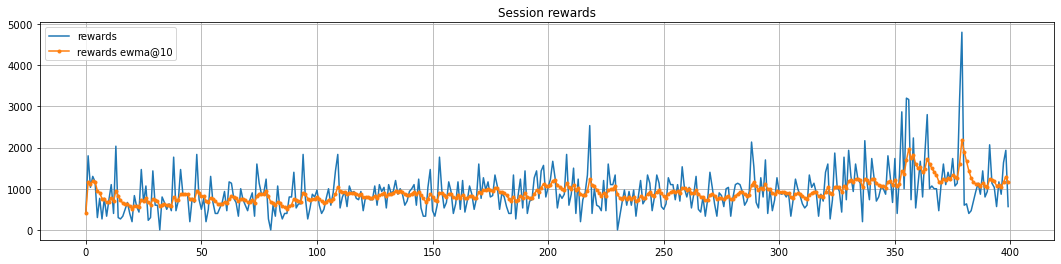

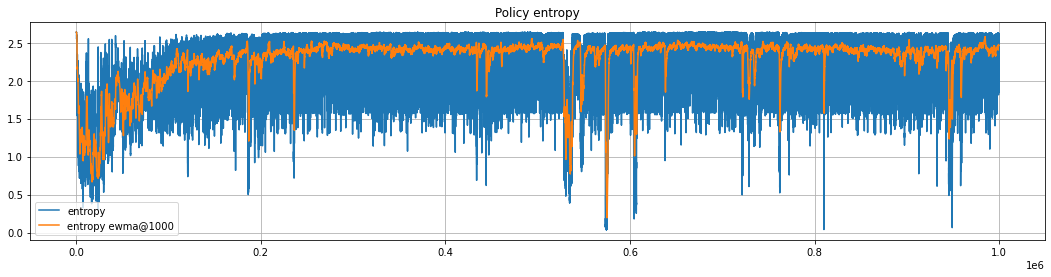

100%|██████████| 1000000/1000000 [7:02:10<00:00, 39.48it/s]


In [16]:
try:
    with tqdm.trange(len(entropy_history), 10**6) as t:
        for i in t:
            #Run sessions
            batch_actions = agent.get_actions(batch_states)
            batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)
            #Reward scaling
            batch_rewards = batch_rewards * 0.01
            #Train!
            loss, ent = agent.train_step(batch_states, batch_actions, batch_rewards, batch_next_states)
            entropy_history.append(ent)
            #Update
            batch_states = batch_next_states

            if i%500 == 0:
                if i %2500 == 0:
                    rewards_history.append(evaluate(agent, n_games=3))
                    if rewards_history[-1] >= 5000:
                        print("Won yellow belt")
                        agent.save()
                clear_output(True)
                
                print("Mean reward: ", rewards_history[-1])
                plt.figure(figsize=[40, 4])
                plt.subplot(1, 2, 1)
                plt.plot(rewards_history, label='rewards')
                plt.plot(ewma(np.array(rewards_history), span=10), marker='.', label='rewards ewma@10')
                plt.title("Session rewards")
                plt.grid()
                plt.legend()

                plt.figure(figsize=[40, 4])
                plt.subplot(1, 2, 2)
                plt.plot(entropy_history, label='entropy')
                plt.plot(ewma(np.array(entropy_history), span=1000), label='entropy ewma@1000')
                plt.title("Policy entropy")
                plt.grid()
                plt.legend()
                plt.show()
            
except KeyboardInterrupt:
    clear_output(True)
    
    print("Mean reward: ", rewards_history[-1])
    plt.figure(figsize=[40, 4])
    plt.subplot(1, 2, 1)
    plt.plot(rewards_history, label='rewards')
    plt.plot(ewma(np.array(rewards_history), span=10), marker='.', label='rewards ewma@10')
    plt.title("Session rewards")
    plt.grid()
    plt.legend()

    plt.figure(figsize=[40, 4])
    plt.subplot(1, 2, 2)
    plt.plot(entropy_history, label='entropy')
    plt.plot(ewma(np.array(entropy_history), span=1000), label='entropy ewma@1000')
    plt.title("Policy entropy")
    plt.grid()
    plt.legend()
    plt.show()

In [17]:
agent.save()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/kung-fu/assets


In [18]:
import gym.wrappers

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    agent.env = env_monitor
    final_rewards = evaluate(agent, n_games=3)

print("Final mean reward:", np.mean(final_rewards))

Final mean reward: 900.0


In [19]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))